In [152]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [93]:
# Load the cleaned dataset
df = pd.read_csv("Cleaned_Bosch_Dataset.csv")

In [94]:
print(df.columns)

Index(['Unnamed: 0', 'Div.', 'Tool_Description', 'Brand', 'Tag_ID',
       'Model_Part_No', 'Serial_No', 'Range', 'Tolerence Limit', 'In_Use',
       'Calibration_Interval_Years', 'Last_Calibration_Date',
       'Next_Calibration_Date', 'Months_Remaining', 'Cal_type',
       'Calibration_Report_No', 'Calibrator', 'P.I.C.', 'Action'],
      dtype='object')


In [95]:
data = pd.read_excel("Bosch Dataset.xlsx", engine="openpyxl")

# Rename relevant columns for clarity
data.rename(columns={
    "Description": "Tool_Description",
    "Brand (Make)": "Brand",
    "Tag": "Tag_ID",
    "Model/Part No": "Model_Part_No",
    "Serial / Id no": "Serial_No",
    "Range": "Range",
    "External": "Ext_Tolerance_Limit",
    "Internal": "Int_Tolerance_Limit",
    "In USE?\n(Y=Yes;\n N=No)": "In_Use",
    "Actual\nCalibration\nInterval\n(No. of Yr)": "Calibration_Interval_Years",
    "Last \nCalibration": "Last_Calibration_Date",
    "Calibration \nDue": "Next_Calibration_Date",
    "Remaining mths before Calibration due date ": "Months_Remaining",
    "1. External Cal:\n In-House / Lab" : "Cal_type",
    "Calibration Report\nNumber ": "Calibration_Report_No",
    "Action for Renewal Reminder": "Action",
}, inplace=True)

In [96]:
# Ensuring important columns remain unchanged
important_columns = ["Range", "Model_Part_Number", "Tolerance"]

for col in important_columns:
        if col in df.columns and col in data.columns:
            df[col] = data[col].astype(str)  # Preserve original format


In [97]:
print(df.head())

   Unnamed: 0 Div.      Tool_Description      Brand Tag_ID    Model_Part_No  \
0         NaN   FA      Blade Micrometer  Hengliang    NaN         691-101A   
1         NaN   FA      Blade Micrometer  Hengliang    NaN         691-102A   
2         NaN   FA       Dial Comparator       MAHR    NIL           865 SE   
3         NaN   FA  Dial Push Pull Gauge      AIKOH    NIL         ANF-500N   
4         NaN   FA  Dial Test Indicators       MAHR    NaN  MarTest 800 SGM   

  Serial_No      Range Tolerence Limit In_Use  Calibration_Interval_Years  \
0    264988     0-25mm             NaN      Y                           2   
1    267754    25-50mm             NaN      Y                           2   
2  81052170  0 - 0.1mm             NaN      Y                           2   
3    126881  0 - 50kgf             NaN      Y                           2   
4  22050743   +/-0.1mm             NaN      Y                           2   

  Last_Calibration_Date Next_Calibration_Date Months_Remaining

In [109]:
# Convert date columns to datetime
df["Last_Calibration_Date"] = pd.to_datetime(df["Last_Calibration_Date"], errors="coerce")
df["Next_Calibration_Date"] = pd.to_datetime(df["Next_Calibration_Date"], errors="coerce")

print("\n Converted Date Columns to Datetime")
print(df[["Last_Calibration_Date", "Next_Calibration_Date"]].head())


 Converted Date Columns to Datetime
  Last_Calibration_Date Next_Calibration_Date
0            2024-10-12            2026-10-12
1            2024-12-06            2026-12-06
2            2023-08-01            2025-08-01
3            2024-12-06            2026-12-06
4            2025-01-07            2027-01-07


In [110]:
# Convert 'Months_Remaining' to numeric
df["Months_Remaining"] = pd.to_numeric(df["Months_Remaining"], errors="coerce")

print("\n Converted 'Months_Remaining' to Numeric")
print(df["Months_Remaining"].head())


 Converted 'Months_Remaining' to Numeric
0    19.700000
1    21.533333
2     5.133333
3    21.533333
4    22.600000
Name: Months_Remaining, dtype: float64


In [111]:
# Summary Statistics
print("\n Dataset Shape:", df.shape)
print("\n Column Data Types:\n", df.dtypes)
print("\n Missing Values:\n", df.isnull().sum())
print("\n Summary Statistics:\n", df.describe())


 Dataset Shape: (159, 18)

 Column Data Types:
 Div.                                  object
Tool_Description                      object
Brand                                 object
Tag_ID                                object
Model_Part_No                         object
Serial_No                             object
Range                                 object
Tolerence Limit                       object
In_Use                                object
Calibration_Interval_Years             int64
Last_Calibration_Date         datetime64[ns]
Next_Calibration_Date         datetime64[ns]
Months_Remaining                     float64
Cal_type                              object
Calibration_Report_No                 object
Calibrator                            object
P.I.C.                                object
Overdue_Flag                            bool
dtype: object

 Missing Values:
 Div.                            0
Tool_Description                0
Brand                           0
Tag_ID

In [112]:
# Fill missing `Tolerence Limit` with "Unknown" instead of dropping
df["Tolerence Limit"].fillna("Unknown", inplace=True)

print("\n Filled missing 'Tolerence Limit' values with 'Unknown'")


 Filled missing 'Tolerence Limit' values with 'Unknown'


<ipython-input-112-c0c41d4d5c52>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Tolerence Limit"].fillna("Unknown", inplace=True)


In [130]:
# Check if there are any missing values to impute
if df["Last_Calibration_Days"].isnull().any():
    lr = LinearRegression()
    train_data = df.dropna(subset=["Last_Calibration_Days"])
    lr.fit(train_data[["Calibration_Interval_Years", "Months_Remaining"]], train_data["Last_Calibration_Days"])

    # Predict only for rows with missing 'Last_Calibration_Days'
    imputation_data = df[df["Last_Calibration_Days"].isnull()][["Calibration_Interval_Years", "Months_Remaining"]]
    imputed_values = lr.predict(imputation_data)

    df.loc[df["Last_Calibration_Days"].isnull(), "Last_Calibration_Days"] = imputed_values  # Assign imputed values to selected rows
    df["Last_Calibration_Date"] = df["Last_Calibration_Date"].min() + pd.to_timedelta(df["Last_Calibration_Days"], unit="D")

    print("\n Imputed missing 'Last_Calibration_Days' values using Linear Regression")
else:
    print("\n No missing 'Last_Calibration_Days' values to impute.")

# Check if there are any missing values to impute
if df["Next_Calibration_Days"].isnull().any():
    lr = LinearRegression()
    train_data = df.dropna(subset=["Next_Calibration_Days"])
    lr.fit(train_data[["Calibration_Interval_Years", "Months_Remaining"]], train_data["Next_Calibration_Days"])

    imputation_data = df[df["Next_Calibration_Days"].isnull()][["Calibration_Interval_Years", "Months_Remaining"]]
    imputed_values = lr.predict(imputation_data)

    df.loc[df["Next_Calibration_Days"].isnull(), "Next_Calibration_Days"] = imputed_values
    df["Next_Calibration_Date"] = df["Next_Calibration_Date"].min() + pd.to_timedelta(df["Next_Calibration_Days"], unit="D")

    print("\n Imputed missing 'Next_Calibration_Days' values using Linear Regression")
else:
    print("\n No missing 'Next_Calibration_Days' values to impute.")


 No missing 'Last_Calibration_Days' values to impute.

 No missing 'Next_Calibration_Days' values to impute.


In [123]:
# Fill missing `Tolerence Limit` with "Unknown" instead of dropping
df["In_Use"].fillna("Unknown", inplace=True)

<ipython-input-123-c891baa94659>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["In_Use"].fillna("Unknown", inplace=True)


In [128]:
# Fill Missing Dates with Median
df["Last_Calibration_Date"].fillna(df["Last_Calibration_Date"].median(), inplace=True)
df["Next_Calibration_Date"].fillna(df["Next_Calibration_Date"].median(), inplace=True)

<ipython-input-128-e439bdd12743>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Last_Calibration_Date"].fillna(df["Last_Calibration_Date"].median(), inplace=True)
<ipython-input-128-e439bdd12743>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

In [125]:
# Recalculate `Months_Remaining`
df["Months_Remaining"] = (df["Next_Calibration_Date"] - datetime.today()).dt.days / 30
df["Months_Remaining"].fillna(df["Months_Remaining"].median(), inplace=True)

<ipython-input-125-e664ade7a4a0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Months_Remaining"].fillna(df["Months_Remaining"].median(), inplace=True)


In [146]:
# Ensure datetime conversion
df["Last_Calibration_Date"] = pd.to_datetime(df["Last_Calibration_Date"], errors="coerce")
df["Next_Calibration_Date"] = pd.to_datetime(df["Next_Calibration_Date"], errors="coerce")

# Create new time-based features
df["Days_Since_Last_Calibration"] = (datetime.today() - df["Last_Calibration_Date"]).dt.days
df["Days_Until_Next_Calibration"] = (df["Next_Calibration_Date"] - datetime.today()).dt.days
df["Calibration_Overdue"] = df["Days_Until_Next_Calibration"] < 0  # Flag overdue calibrations

print("\n Created Time-Based Features:")
print(df[["Days_Since_Last_Calibration", "Days_Until_Next_Calibration", "Calibration_Overdue"]].head())



 Created Time-Based Features:
   Days_Since_Last_Calibration  Days_Until_Next_Calibration  \
0                          140                          589   
1                           85                          644   
2                          578                          152   
3                           85                          644   
4                           53                          676   

   Calibration_Overdue  
0                False  
1                False  
2                False  
3                False  
4                False  


In [126]:
# Fill `P.I.C.` and `Calibration_Report_No`
df["P.I.C."].fillna(df["P.I.C."].mode()[0], inplace=True)
df["Calibration_Report_No"].fillna("Unknown", inplace=True)

<ipython-input-126-a38ab3bff692>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["P.I.C."].fillna(df["P.I.C."].mode()[0], inplace=True)
<ipython-input-126-a38ab3bff692>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [131]:
# Summary Statistics after data handling
print("\n Dataset Shape:", df.shape)
print("\n Column Data Types:\n", df.dtypes)
print("\n Missing Values:\n", df.isnull().sum())
print("\n Summary Statistics:\n", df.describe())


 Dataset Shape: (159, 20)

 Column Data Types:
 Div.                                  object
Tool_Description                      object
Brand                                 object
Tag_ID                                object
Model_Part_No                         object
Serial_No                             object
Range                                 object
Tolerence Limit                       object
In_Use                                object
Calibration_Interval_Years           float64
Last_Calibration_Date         datetime64[ns]
Next_Calibration_Date         datetime64[ns]
Months_Remaining                     float64
Cal_type                              object
Calibration_Report_No                 object
Calibrator                            object
P.I.C.                                object
Overdue_Flag                            bool
Last_Calibration_Days                  int64
Next_Calibration_Days                  int64
dtype: object

 Missing Values:
 Div.              

In [133]:
# Show summary of numerical columns
print("\n Summary Statistics (Numerical Data):\n", df.describe())


 Summary Statistics (Numerical Data):
        Calibration_Interval_Years          Last_Calibration_Date  \
count                  159.000000                            159   
mean                     1.867925  2024-05-03 01:30:18.441653504   
min                      1.000000            2022-02-16 00:00:00   
25%                      2.000000            2023-08-01 00:00:00   
50%                      2.000000            2024-08-26 00:00:00   
75%                      2.000000            2024-11-29 00:00:00   
max                      2.000000            2025-01-18 00:00:00   
std                      0.339643                            NaN   

               Next_Calibration_Date  Months_Remaining  Last_Calibration_Days  \
count                            159        159.000000             159.000000   
mean   2026-03-15 07:32:49.811320832         12.610482             807.056604   
min              2024-02-16 00:00:00        -12.666667               0.000000   
25%              2025-0

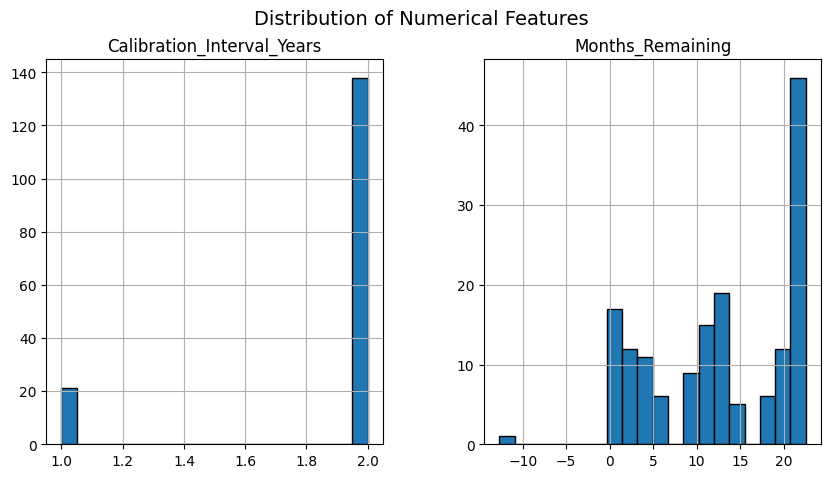

In [134]:
# Histogram of Numerical Features
df[["Calibration_Interval_Years", "Months_Remaining"]].hist(figsize=(10, 5), bins=20, edgecolor="black")
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

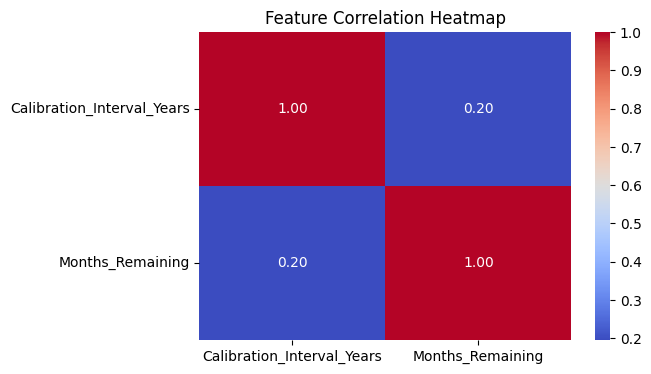

In [135]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[["Calibration_Interval_Years", "Months_Remaining"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

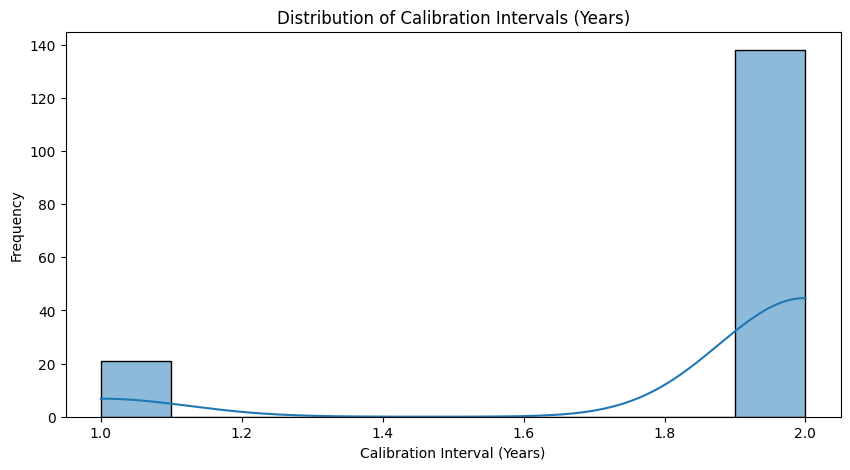

In [142]:
# Exploratory Data Analysis (EDA)
# Distribution of Calibration Intervals
plt.figure(figsize=(10, 5))
sns.histplot(df["Calibration_Interval_Years"].dropna(), bins=10, kde=True)
plt.title("Distribution of Calibration Intervals (Years)")
plt.xlabel("Calibration Interval (Years)")
plt.ylabel("Frequency")
plt.show()

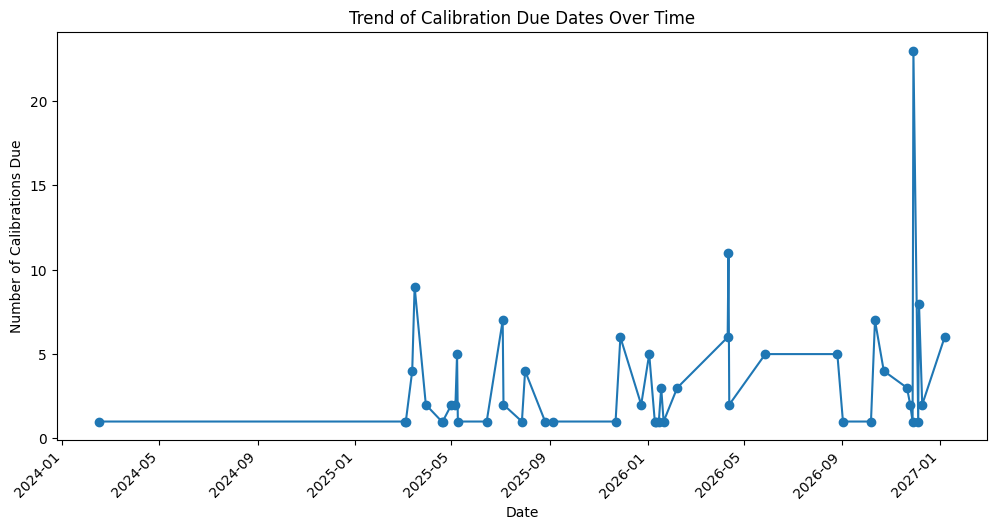

In [143]:
# Trend of upcoming calibration due dates
plt.figure(figsize=(12, 6))
df["Next_Calibration_Date"].dropna().value_counts().sort_index().plot(kind="line", marker='o', linestyle='-')
plt.title("Trend of Calibration Due Dates Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Calibrations Due")
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x500 with 0 Axes>

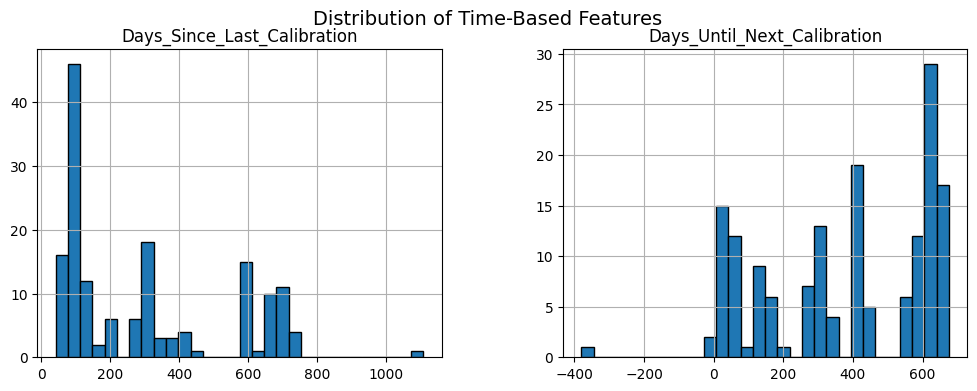

In [147]:
# Histogram of Time-Based Features
plt.figure(figsize=(12, 5))
df[["Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]].hist(bins=30, edgecolor="black", layout=(1,2), figsize=(12,4))
plt.suptitle("Distribution of Time-Based Features", fontsize=14)
plt.show()

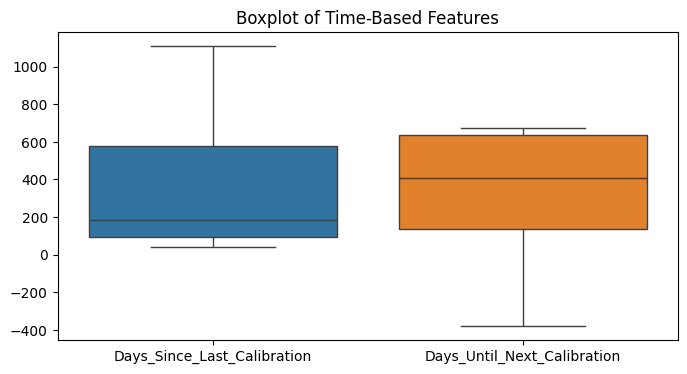

In [149]:
# Boxplot to Check for Outliers
plt.figure(figsize=(8, 4))
sns.boxplot(data=df[["Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]])
plt.title("Boxplot of Time-Based Features")
plt.show()

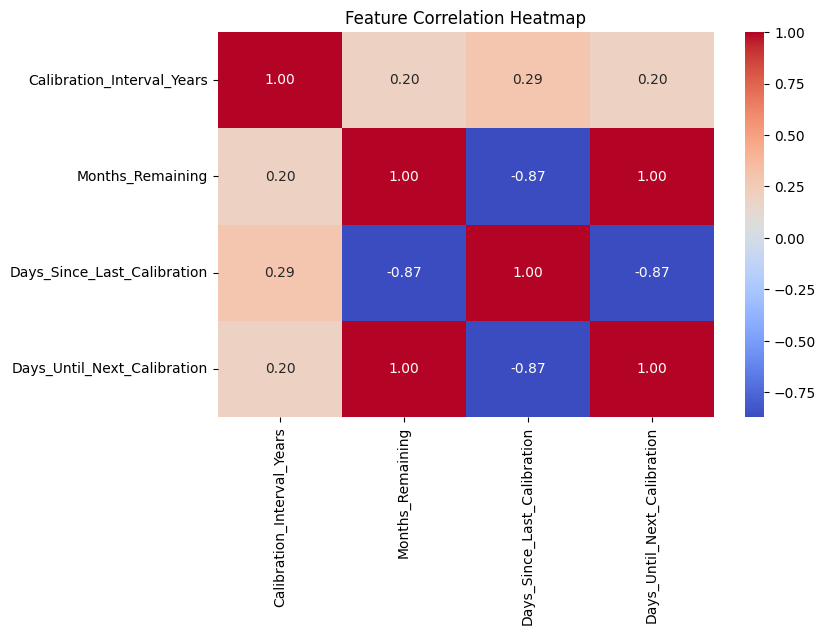

In [151]:
# Correlation Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df[["Calibration_Interval_Years", "Months_Remaining", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

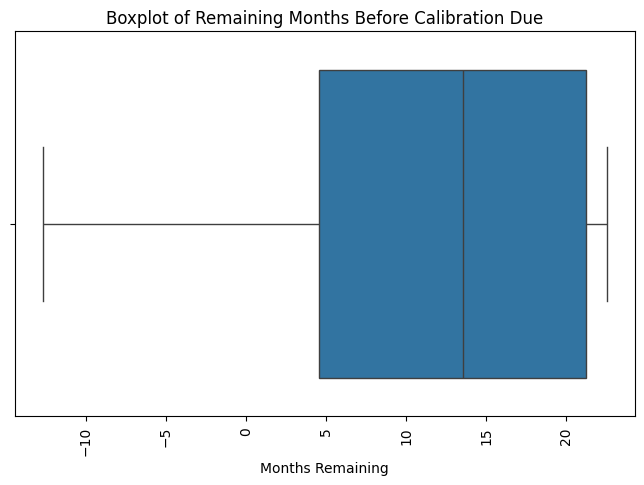

In [148]:
# Boxplot of remaining months before calibration is due
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Months_Remaining"].dropna())
plt.title("Boxplot of Remaining Months Before Calibration Due")
#Rotate 90 degree
plt.xticks(rotation=90)
plt.xlabel("Months Remaining")
plt.show()

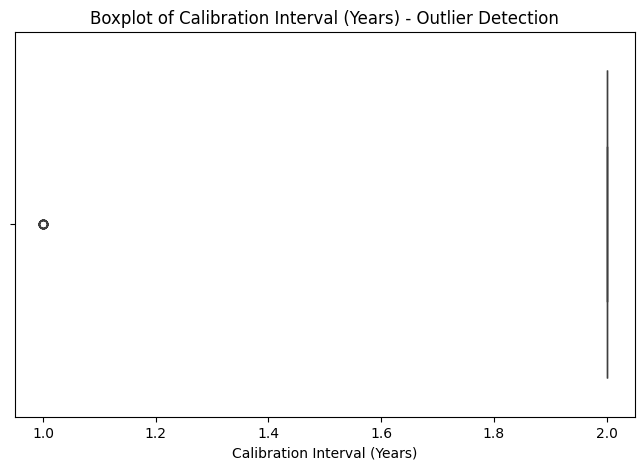

In [150]:
# Anomaly Detection - Identify Outliers in Calibration Intervals
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Calibration_Interval_Years"].dropna())
plt.title("Boxplot of Calibration Interval (Years) - Outlier Detection")
plt.xlabel("Calibration Interval (Years)")
plt.show()

<Figure size 1000x400 with 0 Axes>

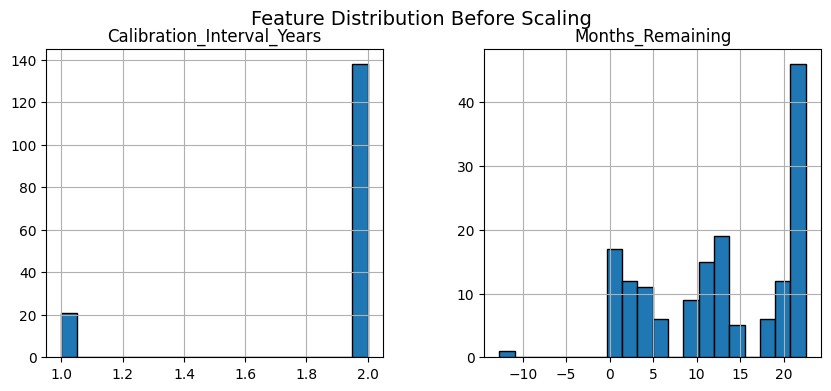

<Figure size 1000x400 with 0 Axes>

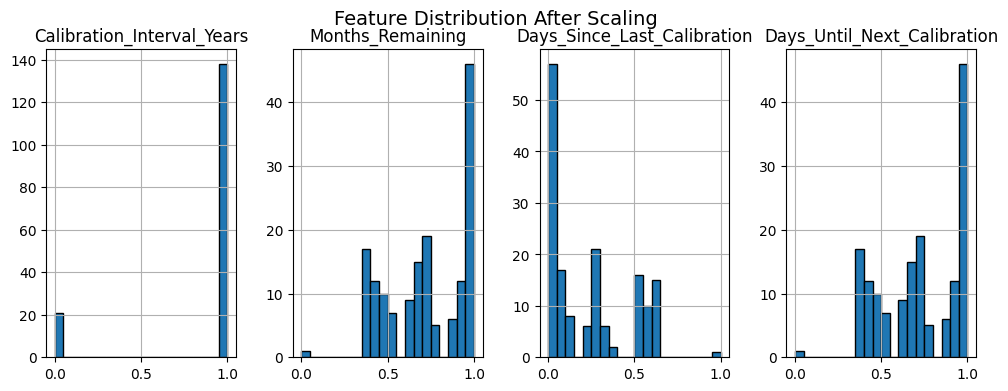

In [153]:
# Before Scaling
plt.figure(figsize=(10, 4))
df[["Calibration_Interval_Years", "Months_Remaining"]].hist(bins=20, edgecolor="black", layout=(1,2), figsize=(10,4))
plt.suptitle("Feature Distribution Before Scaling", fontsize=14)
plt.show()

# Apply Scaling

scaler = MinMaxScaler()
num_cols = ["Calibration_Interval_Years", "Months_Remaining", "Days_Since_Last_Calibration", "Days_Until_Next_Calibration"]
df[num_cols] = scaler.fit_transform(df[num_cols])

# After Scaling
plt.figure(figsize=(10, 4))
df[num_cols].hist(bins=20, edgecolor="black", layout=(1,4), figsize=(12,4))
plt.suptitle("Feature Distribution After Scaling", fontsize=14)
plt.show()

In [136]:
# Create a new column to flag overdue calibrations

# Create Time-Based Features
df["Days_Since_Last_Calibration"] = (datetime.today() - df["Last_Calibration_Date"]).dt.days
df["Days_Until_Next_Calibration"] = (df["Next_Calibration_Date"] - datetime.today()).dt.days

df["Overdue_Flag"] = df["Months_Remaining"] < 0

# Count overdue tools
print("\n Number of Overdue Tools:", df["Overdue_Flag"].sum())

# Display overdue tools
print("\n Overdue Tools:")
print(df[df["Overdue_Flag"] == True][["Tool_Description", "Next_Calibration_Date", "Months_Remaining"]])


 Number of Overdue Tools: 1

 Overdue Tools:
                    Tool_Description Next_Calibration_Date  Months_Remaining
130  (B.1)  LHD Test Rig: Flow meter            2024-02-16        -12.666667


In [137]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
print("\n🔹 Categorical Columns:", cat_cols)


🔹 Categorical Columns: ['Div.', 'Tool_Description', 'Brand', 'Tag_ID', 'Model_Part_No', 'Serial_No', 'Range', 'Tolerence Limit', 'In_Use', 'Cal_type', 'Calibration_Report_No', 'Calibrator', 'P.I.C.']


In [138]:
# Show unique values in categorical columns
print("\n🔹 Unique Values in Categorical Columns:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")


🔹 Unique Values in Categorical Columns:
Div.: 3 unique values
Tool_Description: 117 unique values
Brand: 31 unique values
Tag_ID: 84 unique values
Model_Part_No: 93 unique values
Serial_No: 159 unique values
Range: 83 unique values
Tolerence Limit: 10 unique values
In_Use: 2 unique values
Cal_type: 4 unique values
Calibration_Report_No: 159 unique values
Calibrator: 6 unique values
P.I.C.: 5 unique values


In [140]:
# Label Encoding for Binary & Ordinal Features
label_encoders = {}
binary_cols = ["In_Use", "Tolerence Limit"]

for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for later decoding

# One-Hot Encoding for Nominal Categorical Variables
one_hot_cols = ["Brand", "Calibrator"]
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)  # Avoid multicollinearity

print("\n Categorical Features Encoded Successfully!")
print(df.head())


 Categorical Features Encoded Successfully!
  Div.      Tool_Description Tag_ID    Model_Part_No Serial_No      Range  \
0   FA      Blade Micrometer     NA         691-101A    264988     0-25mm   
1   FA      Blade Micrometer     NA         691-102A    267754    25-50mm   
2   FA       Dial Comparator    NIL           865 SE  81052170  0 - 0.1mm   
3   FA  Dial Push Pull Gauge    NIL         ANF-500N    126881  0 - 50kgf   
4   FA  Dial Test Indicators     NA  MarTest 800 SGM  22050743   +/-0.1mm   

   Tolerence Limit  In_Use  Calibration_Interval_Years Last_Calibration_Date  \
0                4       1                         2.0            2024-10-12   
1                4       1                         2.0            2024-12-06   
2                4       1                         2.0            2023-08-01   
3                4       1                         2.0            2024-12-06   
4                4       1                         2.0            2025-01-07   

   ... Bran

In [141]:
#Verifying Encoding

print("\n Final Dataset Columns:", df.columns)


 Final Dataset Columns: Index(['Div.', 'Tool_Description', 'Tag_ID', 'Model_Part_No', 'Serial_No',
       'Range', 'Tolerence Limit', 'In_Use', 'Calibration_Interval_Years',
       'Last_Calibration_Date', 'Next_Calibration_Date', 'Months_Remaining',
       'Cal_type', 'Calibration_Report_No', 'P.I.C.', 'Overdue_Flag',
       'Last_Calibration_Days', 'Next_Calibration_Days',
       'Days_Since_Last_Calibration', 'Days_Until_Next_Calibration',
       'Brand_ACEZ', 'Brand_AIKOH', 'Brand_AW-LAKE', 'Brand_Azono',
       'Brand_CAPRI', 'Brand_DC/LT-DE', 'Brand_Dunkes', 'Brand_ECE',
       'Brand_ELORA', 'Brand_FLUKE', 'Brand_Force', 'Brand_HOLEX',
       'Brand_HYDROTECHNIK', 'Brand_Hengliang', 'Brand_Hydrotechnik',
       'Brand_IMADA', 'Brand_KANON', 'Brand_KARL', 'Brand_MAHR',
       'Brand_MITUTOYO', 'Brand_OPUS', 'Brand_PREMIUM', 'Brand_Preisser ',
       'Brand_REXROTH', 'Brand_SHIMPO', 'Brand_STAHLWILLE', 'Brand_Sanliang',
       'Brand_TESA', 'Brand_TOHNICHI', 'Brand_WIKA',
       